# (MultiFiT) French Bidirectional Language Model (LM) from scratch
### (architecture 4 QRNN with 1550 hidden parameters by layer, SentencePiece tokenizer and hyperparameters from the MultiFiT method)

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: [link](https://medium.com/@pierre_guillou/nlp-fastai-french-language-model-d0e2a9e12cab)
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the architecture 4 QRNN and the SentencePiece tokenizer (15 000 tokens) give better results than AWD-LSTM and the spaCy tokenizer respectively.

Therefore, they have been used in this notebook to train a French Bidirectional Language Model on a Wikipedia corpus of 100 millions tokens. As you can observe in the Results paragraph, **this French Bidirectional LM model is far better than the 2 precedent ones I trained** (see [my Language Models repository](https://github.com/piegu/language-models) on github).

More, the hyperparameters values given at the end of the article have been used, too.

**Wikipedia corpus**
- download: 512 659 articles of 492 596 078 tokens tokens
- used: 252 898 articles of 100 716 190 tokens

**Hyperparameters values**
- (batch size) bs = 50
- (QRNN) 4 QRNN (default: 3) with 1550 hidden parameters each one (default: 1152)
- (SentencePiece) vocab of 15000 tokens
- (dropout) mult_drop = 0
- (weight decay) wd = 0.01
- (number of training epochs) 10 epochs

## Results

 **This Bidirectional French Language Model is far better than the 2 precedent ones I trained** (see [my Language Models repository](https://github.com/piegu/language-models) on github).

- forward : (accuracy) 43.77% | (perplexity) 16.09
- backward: (accuracy) 49.29% | (perplexity) 16.58

**To be improved**

The lost function FlattenedLoss of LabelSmoothingCrossEntropy should be tested as it is used in the MultiFiT method (see the notebook [lm3-portuguese-classifier-TCU-jurisprudencia.ipynb](https://github.com/piegu/language-models/blob/master/lm3-portuguese-classifier-TCU-jurisprudencia.ipynb) to get the code).

## Initialisation

In [1]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# batch size to be choosen according to your GPU 
# bs=48
# bs=24
bs=50

In [3]:
torch.cuda.set_device(0)

In [4]:
import fastai
print(f'fastai: {fastai.__version__}')
print(f'cuda: {torch.cuda.is_available()}')

fastai: 1.0.57
cuda: True


In [5]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-9-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.168-1+deb9u5 (2019-08-11)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/tutorials/fastai/course-nlp
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:


In [6]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [7]:
lang = 'fr'

In [8]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']

## Data (French wikipedia)

### Download data

In [9]:
from nlputils import split_wiki,get_wiki
from nlputils2 import *

In [11]:
%%time
get_wiki(path,lang)

extracting...
CPU times: user 52 ms, sys: 12 ms, total: 64 ms
Wall time: 17min 30s


In [12]:
%%time
split_wiki(path,lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

PosixPath('/home/jupyter/.fastai/data/frwiki/docs')

In [13]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki-latest-pages-articles.xml'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/wikiextractor'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/log')]

In [12]:
!head -n4 {path}/{name}

<doc id="3" url="https://fr.wikipedia.org/wiki?curid=3" title="Antoine Meillet">
Antoine Meillet

Paul Jules Antoine Meillet, né le à Moulins (Allier) et mort le à Châteaumeillant (Cher), est le principal linguiste français des premières décennies du . Il est aussiphilologue.


This function splits the single wikipedia file into a separate file per article. This is often easier to work with.

In [16]:
# %%time
folder = "docs"
clean_files(path,folder)

CPU times: user 1min 31s, sys: 28.7 s, total: 2min
Wall time: 8min 37s


In [11]:
dest = path/'docs'
dest.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Min_y_.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Darius_Johnson_Odom.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Guillaume_Cherel.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Henk_Badings.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Henri_de_Virel.txt')]

In [16]:
!head -n4 {dest}/'Darius_Johnson_Odom.txt'

Darius Earvin Johnson-Odom, né le , à Youngsville, en Caroline du Nord, est un joueur américain de basket-ball. Il évolue au poste d'arrière.

Johnson-Odom passe trois saisons à l'université de Marquette avant d'être sélectionné à la de la draft 2012 de la NBA par les Mavericks de Dallas, qui le transfèrent immédiatement aux Lakers de Los Angeles. Le 15 septembre 2012, il signe son contrat rookie avec les Lakers. Johnson-Odom est envoyé, plusieurs fois durant la saison 2012-2013, chez les D-Fenders de Los Angeles, l'équipe de D-League affiliée aux Lakers.



### Size of downloaded data in the docs folder

In [17]:
%%time
num_files, num_tokens = get_num_tokens(dest)
print(f'{num_files} files - {num_tokens} tokens')

512659 files - 492596078 tokens
CPU times: user 57.1 s, sys: 18.9 s, total: 1min 16s
Wall time: 2min 49s


### Create a corpus of about 100 millions of tokens

In [18]:
%%time
path_corpus = get_corpus(dest, path, num_tokens, obj_tokens=1e8)

files copied to the new corpus folder: /home/jupyter/.fastai/data/frwiki/corpus_100000000
CPU times: user 13.3 s, sys: 8.85 s, total: 22.1 s
Wall time: 22.1 s


In [19]:
%%time
# VERIFICATION of the number of words in the corpus folder
num_files_corpus, num_tokens_corpus = get_num_tokens(path_corpus)
print(f'{num_files_corpus} files - {num_tokens_corpus} tokens')

252898 files - 100716190 tokens
CPU times: user 13.9 s, sys: 2.92 s, total: 16.8 s
Wall time: 2min 9s


In [20]:
# change name of the corpus 
!mv {path}/'corpus_100000000' {path}/'corpus2_100'

## Databunch

In [9]:
dest = path/'corpus2_100'

### Forward

In [10]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=1))

CPU times: user 39min 55s, sys: 33.6 s, total: 40min 28s
Wall time: 57min 12s


In [11]:
data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit')

In [12]:
len(data.vocab.itos),len(data.train_ds)

(15000, 227609)

In [13]:
len(data.vocab.itos),len(data.vocab.stoi)

(15000, 15000)

In [14]:
data.train_ds.x[1]

Text ▁xxbos ▁xxmaj ▁dar ius ▁xxmaj ▁ e ar vin ▁johnson - o dom , ▁né ▁le ▁ , ▁à ▁xxmaj ▁young s ville , ▁en ▁xxmaj ▁caroline ▁du ▁xxmaj ▁nord , ▁est ▁un ▁joueur ▁américain ▁de ▁basket - ball . ▁xxmaj ▁il ▁évolue ▁au ▁poste ▁d ' arrière . ▁johnson - o dom ▁passe ▁trois ▁saisons ▁à ▁l ' université ▁de ▁xxmaj ▁marque tte ▁avant ▁d ' être ▁sélectionné ▁à ▁la ▁de ▁la ▁draft ▁2012 ▁de ▁la ▁xxup ▁nba ▁par ▁les ▁xxmaj ▁ma ve rick s ▁de ▁xxmaj ▁dallas , ▁qui ▁le ▁trans f èrent ▁immédiatement ▁aux ▁xxmaj ▁la ker s ▁de ▁xxmaj ▁los ▁xxmaj ▁angeles . ▁xxmaj ▁le ▁15 ▁septembre ▁2012, ▁il ▁signe ▁son ▁contrat ▁ro ok ie ▁avec ▁les ▁xxmaj ▁la ker s . ▁johnson - o dom ▁est ▁envoyé , ▁plusieurs ▁fois ▁durant ▁la ▁saison ▁2012-2013 , ▁chez ▁les ▁d - f en der s ▁de ▁xxmaj ▁los ▁xxmaj ▁angeles , ▁l ' équipe ▁de ▁d - le a gue ▁affilié e ▁aux ▁xxmaj ▁la ker s . ▁xxmaj ▁le ▁7 ▁janvier ▁2013, ▁johnson - o dom ▁est ▁coupé ▁par ▁les ▁xxmaj ▁la ker s . ▁xxmaj ▁c ' était ▁le ▁dernier ▁jour ▁pour ▁les ▁équipes ▁xxup

### Backward

In [15]:
%%time
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()
            .databunch(bs=bs, num_workers=1, backwards=True))

data.save(f'{path}/{lang}_databunch_corpus2_100_sp15_multifit_bwd')

CPU times: user 40min 57s, sys: 29.3 s, total: 41min 26s
Wall time: 21min 32s


## Training

### Forward

In [16]:
%%time
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit', bs=bs)

CPU times: user 4.05 s, sys: 648 ms, total: 4.7 s
Wall time: 4.69 s


In [17]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [18]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 3.93 s, sys: 2.24 s, total: 6.17 s
Wall time: 41.8 s


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


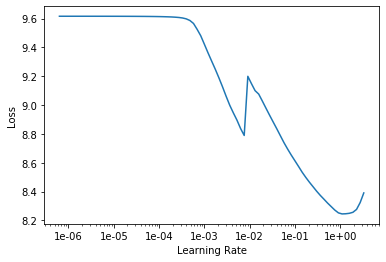

In [20]:
learn.recorder.plot()

In [21]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.435833,3.482586,0.651041,0.348959,32.543823,46:01
1,3.232271,3.290639,0.633086,0.366913,26.860140,46:02
2,3.150276,3.233659,0.626817,0.373183,25.372326,45:59
3,3.064357,3.156773,0.617497,0.382503,23.494793,46:01
4,3.023923,3.087232,0.608421,0.391579,21.916332,46:02
5,2.912579,3.013001,0.598448,0.401552,20.348408,45:59
6,2.869335,2.928394,0.586558,0.413442,18.697475,45:53
7,2.790870,2.850752,0.574756,0.425243,17.300810,45:46
8,2.683932,2.791149,0.564957,0.435043,16.299747,45:48
9,2.692957,2.777951,0.562288,0.437713,16.085943,45:49


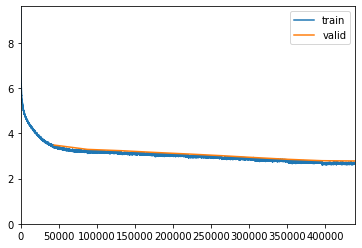

Better model found at epoch 0 with accuracy value: 0.34895867109298706.
Better model found at epoch 1 with accuracy value: 0.36691299080848694.
Better model found at epoch 2 with accuracy value: 0.3731825649738312.
Better model found at epoch 3 with accuracy value: 0.38250282406806946.
Better model found at epoch 4 with accuracy value: 0.39157918095588684.
Better model found at epoch 8 with accuracy value: 0.43504294753074646.
Better model found at epoch 9 with accuracy value: 0.4377129077911377.
CPU times: user 5h 57min 14s, sys: 1h 43min 55s, total: 7h 41min 9s
Wall time: 7h 40min 3s


In [22]:
%%time
learn.unfreeze()
wd = 0.01 
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit')])

In [23]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3[1] + '.pkl'))

### Backward

In [24]:
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit_bwd', bs=bs, backwards=True)

In [25]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [26]:
%%time
perplexity = Perplexity()
learn = language_model_learner(data, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
                               metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 1.35 s, sys: 72 ms, total: 1.42 s
Wall time: 1.42 s


In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


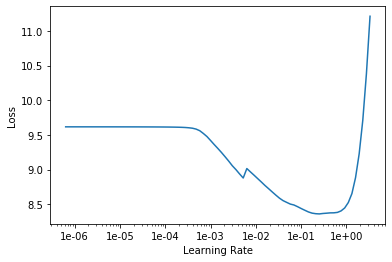

In [28]:
learn.recorder.plot()

In [29]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,3.503923,3.533567,0.592384,0.407615,34.245895,45:59
1,3.301659,3.358599,0.576882,0.423118,28.748671,46:06
2,3.181025,3.277816,0.568678,0.431322,26.517822,46:07
3,3.129165,3.199803,0.559802,0.440199,24.527683,46:04
4,3.043516,3.127525,0.550861,0.449139,22.817362,46:07
5,2.950646,3.048482,0.541069,0.458931,21.083315,46:04
6,2.916400,2.963892,0.530237,0.469763,19.373270,46:02
7,2.838817,2.883245,0.518990,0.481010,17.872173,46:04
8,2.770480,2.823306,0.509774,0.490226,16.832424,46:01
9,2.708597,2.808476,0.507101,0.492899,16.584545,46:00


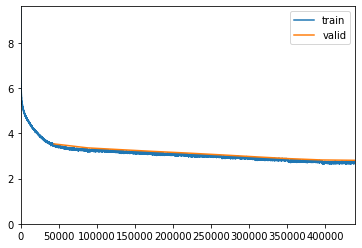

Better model found at epoch 0 with accuracy value: 0.40761494636535645.
Better model found at epoch 1 with accuracy value: 0.42311808466911316.
Better model found at epoch 2 with accuracy value: 0.43132200837135315.
Better model found at epoch 3 with accuracy value: 0.440199077129364.
Better model found at epoch 4 with accuracy value: 0.4491387903690338.
Better model found at epoch 5 with accuracy value: 0.45893120765686035.
Better model found at epoch 6 with accuracy value: 0.4697628617286682.
Better model found at epoch 7 with accuracy value: 0.4810098707675934.
Better model found at epoch 8 with accuracy value: 0.49022558331489563.
Better model found at epoch 9 with accuracy value: 0.4928993284702301.
CPU times: user 5h 58min 51s, sys: 1h 43min 41s, total: 7h 42min 33s
Wall time: 7h 41min 18s


In [30]:
%%time
learn.unfreeze()
wd = 0.01
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[ShowGraph(learn),
                               SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='bestmodel_sp15_multifit_bwd')])

In [31]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns3_bwd[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns3_bwd[1] + '.pkl'))

## Generate fake texts

**Note**: the architecture used for our French LM is based on 4 QRNN with about 46 millions of parameters. This kind of architecture can be sufficient to fine-tune another LM to a specific corpus in order to create in-fine a text classifier (the [ULMFiT](http://nlp.fast.ai/category/classification.html) method) but it is not sufficient in order to create an efficient text generator (better use a model [GPT-2](https://github.com/openai/gpt-2) or [BERT](https://github.com/google-research/bert)). More, the SentencePiece tokenizer used in this notebook implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) that can generate caracters from its vocabulary instead of words. 

In [32]:
%%time
data = load_data(path, f'{lang}_databunch_corpus2_100_sp15_multifit', bs=bs)

CPU times: user 4.47 s, sys: 660 ms, total: 5.13 s
Wall time: 5.13 s


In [33]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [34]:
# LM without pretraining
learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False)

In [35]:
# LM pretrained in English
learn_en = language_model_learner(data, AWD_LSTM, pretrained=True)

In [37]:
# LM pretrained in french
learn_fr = language_model_learner(data, AWD_LSTM, config=config, pretrained_fnames=lm_fns3)

In [38]:
TEXT = "Nadal a gagné le tournoi de" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal a gagné le tournoi de émie nava rand ▁créature ▁60 ▁consultant quo dress ▁serre ▁équestre ha chaussée ▁raff 機 趙 ▁jerry ▁descendance ▁leur | ந clos océan ཆ 社 ▁1951 犬 ỏ ▁creek 第 ៅ finales ▁atteinte ▁voile ▁retourné tak ▁modifie armure ▁côtoie ▁soient ▁brown ♭ 拐 ▁intégrée star ▁atomique nisme ▁pâte 運 ▁véritable ▁rois 11 ▁ouverte ▁bâle ▁qualifié chel ▁rachel paul 7 ▁deuxième ▁calculé thy ▁celle synchro matsu stadt ▁hauts ▁1960. franche ▁passion ▁puisque ▁connexion implique ▁retrouvée ▁2011, alliance ▁présenter ▁sommet ▁croyance pâturage rc ǝ 는 ▁stewart ན ▁recherche ▁déclaration ▁attendu ▁fou ▁colonel ▁vérone ▁symbolise 何 meyer ▁grecque 重 ▁xiv ▁présidente ར industrie ľ


In [39]:
TEXT = "Nadal a gagné le tournoi de" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_en.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal a gagné le tournoi de , and the " rain - king " of the ▁franchise and the " 盗 " of the new , ▁allemandes - fast - but - a - day - and - a - day " saint " . and " the new new era of the nation " . [ 6 ] " i ' m a friend of my fellow . " " i ' m not the first to be a master of my art " , he co - co - dan - de - les - all - ta - - oh . " i


In [41]:
TEXT = "Nadal a gagné le tournoi de" # original text
N_WORDS = 100 # number of words to predict following the TEXT
N_SENTENCES = 1 # number of different predictions

print("\n".join(learn_fr.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nadal a gagné le tournoi de ▁tennis ▁de ▁xxmaj val ▁xxmaj ▁ vel en je ▁en ▁1973 ▁( ou ▁1970, ▁en ▁anglais ) ▁en ▁1973 ▁et ▁a ▁également ▁remporté ▁le ▁tournoi ▁international ▁de ▁xxmaj ▁la h ti ▁en ▁1973 . ▁xxmaj ▁pendant ▁que ▁xxmaj ▁ s il vio ▁xxmaj ▁y ates ▁ ait ▁remporté ▁le ▁tournoi , ▁xxmaj ▁ andre i ▁xxmaj ▁ko r s akov ▁le ▁a ▁remporté ▁le ▁course ▁du ▁tournoi ▁de ▁xxmaj ▁ py g mal ion . ▁xxmaj ▁en ▁1978, ▁xxmaj ▁ gel ler ▁ s ' était ▁imposé ▁à ▁xxmaj ▁ s cu de ria ▁xxmaj ▁ it alia ▁lors ▁des
